In [3]:
import torch
from datasets import load_dataset

In [1]:
from transformers import pipeline;
print(pipeline('sentiment-analysis')('I love you'))
# Should return a label and a score

/opt/anaconda3/envs/pt_env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/opt/anaconda3/envs/pt_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'label': 'POSITIVE', 'score': 0.9998656511306763}]


In [4]:
print(torch.__version__)

2.5.1


In [5]:
print(torch.backends.mps.is_available())

True


In [6]:
torch.backends.mps.is_built()

True

In [7]:
trec = load_dataset('trec', split='train[:1000]')
trec

/opt/anaconda3/envs/pt_env/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for trec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/trec
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1000
})

In [8]:
trec[0]

{'text': 'How did serfdom develop in and then leave Russia ?',
 'coarse_label': 2,
 'fine_label': 26}

In [9]:
from transformers import pipeline

In [10]:
from transformers import BertTokenizer, BertModel

/opt/anaconda3/envs/pt_env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [12]:
tokanizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [13]:
text = trec['text'][:64]
tokens = tokanizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

In [14]:
%%timeit
model(**tokens)

268 ms ± 5.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Now model running on mps

In [15]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [16]:
%%timeit
model(**tokens)

40.1 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
text = trec['text'][:256]
tokens = tokanizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

device = torch.device('cpu')
model.to(device)
device

device(type='cpu')

In [18]:
%%timeit
model(**tokens)

1.47 s ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [20]:
%%timeit
model(**tokens)

268 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
text = trec['text'][:8]
tokens = tokanizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

device = torch.device('cpu')
model.to(device)
device

device(type='cpu')

In [22]:
%%timeit
model(**tokens)

69.3 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [24]:
%%timeit
model(**tokens)

12.6 ms ± 161 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
from time import time

reruns = 6
b = 10

# start with CPU test
device = torch.device('cpu')
model.to(device)

cpu_times = []

for i in range(b):
    text = trec['text'][:2**i]
    tokens = tokanizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    )
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    cpu_times.append(tot_time/reruns)

# then GPU test
device = torch.device('mps')
model.to(device)

mps_times = []

for i in range(b):
    text = trec['text'][:2**i]
    tokens = tokanizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    ).to(device)
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    mps_times.append(tot_time/reruns)

<Axes: >

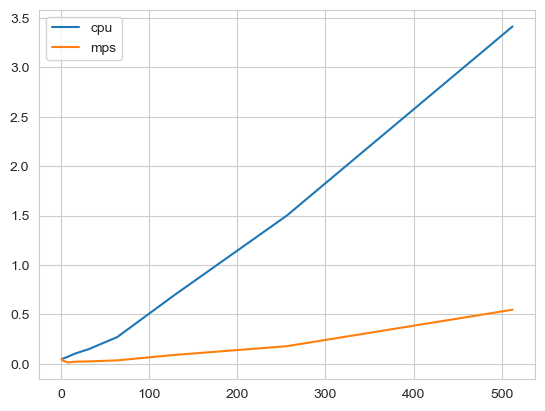

In [26]:
import seaborn as sns

sns.set_style('whitegrid')

sns.lineplot(
    x=[2**i for i in range(b)]*2,
    y=cpu_times+mps_times,
    hue=['cpu']*b + ['mps']*b
)